# Leah Contract Review Evaluation Pipeline

This notebook walks through the evaluation framework for benchmarking AI-powered contract review against expert legal ground truth.

**What this covers:**
- Loading and exploring 160+ hand-authored ground truth issues across 10 contract types
- Understanding the three-tier scoring system (T1/T2/T3) and quality dimensions
- Demonstrating the scoring engine with real evaluation data
- Comparing 6 AI models on detection rate, T1 gate pass rate, and quality scores
- Visualising results with heatmaps and comparison charts

In [1]:
import json
import sys
from pathlib import Path

import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import numpy as np

# Discover project root by walking upward to find pyproject.toml
_here = Path.cwd()
PROJECT_ROOT = _here
for _parent in [_here] + list(_here.parents):
    if (_parent / "pyproject.toml").exists():
        PROJECT_ROOT = _parent
        break
sys.path.insert(0, str(PROJECT_ROOT))

from framework.scoring import calculate_detection_points, calculate_weighted_recall

# Contract display names (avoids .title() mangling JV, DPA, SLA, etc.)
CONTRACT_LABELS = {
    "consulting": "Consulting",
    "dpa": "DPA",
    "distribution": "Distribution",
    "jv": "JV",
    "license": "License",
    "partnership": "Partnership",
    "reseller": "Reseller",
    "services": "Services",
    "sla": "SLA",
    "supply": "Supply",
}

# Key directories
GT_DIR = PROJECT_ROOT / "freeform" / "ground_truth"
RESULTS_DIR = PROJECT_ROOT / "freeform" / "results"
CONFIG_DIR = PROJECT_ROOT / "framework" / "config"

# Load freeform scoring configuration
with open(CONFIG_DIR / "freeform.json") as f:
    config = json.load(f)

tier_config = config["detection_points"]
contracts = config["contracts"]
models = config["models"]

print(f"Project root: {PROJECT_ROOT}")
print(f"Contracts: {len(contracts)}")
print(f"Models: {len(models)}")
print(f"Tier config: {json.dumps(tier_config, indent=2)}")

Project root: /Users/liz/Projects/leah-contract-review-evaluation
Contracts: 10
Models: 6
Tier config: {
  "T1": {
    "Y": 8,
    "P": 4,
    "N": 0,
    "NMI": 0
  },
  "T2": {
    "Y": 5,
    "P": 2.5,
    "N": 0,
    "NMI": 0
  },
  "T3": {
    "Y": 1,
    "P": 0.5,
    "N": 0,
    "NMI": 0
  }
}


In [2]:
# Load ground truth across all 10 contracts
gt_data = {}
tier_counts = {"T1": 0, "T2": 0, "T3": 0}
rows = []

for contract in contracts:
    gt_path = GT_DIR / f"{contract}.json"
    if not gt_path.exists():
        print(f"  Missing: {contract}")
        continue
    with open(gt_path) as f:
        gt = json.load(f)
    gt_data[contract] = gt
    issues = gt["ground_truth"]
    t1 = sum(1 for i in issues if i["tier"] == "T1")
    t2 = sum(1 for i in issues if i["tier"] == "T2")
    t3 = sum(1 for i in issues if i["tier"] == "T3")
    tier_counts["T1"] += t1
    tier_counts["T2"] += t2
    tier_counts["T3"] += t3
    party = gt["gt_metadata"]["representing_party"]
    rows.append({
        "Contract": CONTRACT_LABELS.get(contract, contract),
        "Representing Party": party,
        "T1": t1, "T2": t2, "T3": t3,
        "Total": len(issues),
    })

gt_df = pd.DataFrame(rows)
print(f"\nGround Truth Summary: {sum(tier_counts.values())} issues")
print(f"  T1 (Critical):  {tier_counts['T1']}")
print(f"  T2 (Material):  {tier_counts['T2']}")
print(f"  T3 (Minor):     {tier_counts['T3']}")
print()
gt_df


Ground Truth Summary: 160 issues
  T1 (Critical):  45
  T2 (Material):  78
  T3 (Minor):     37



,Contract,Representing Party,T1,T2,T3,Total
0,Consulting,Meridian Enterprises Inc. (Client),1,8,2,11
1,DPA,Controller,3,6,3,12
2,Distribution,Distributor,6,5,2,13
3,JV,Quantum Dynamics LLC (Party B),5,10,3,18
4,License,TechPro Industries Corp. (Licensee),4,7,4,15
5,Partnership,Growth Dynamics Partners LP (Partner B),6,4,2,12
6,Reseller,Pacific Tech Distributors LLC (Reseller),4,7,2,13
7,Services,Client,4,11,11,26
8,SLA,Licensee,8,12,6,26
9,Supply,Apex Automotive Systems Inc. (Buyer),4,8,2,14


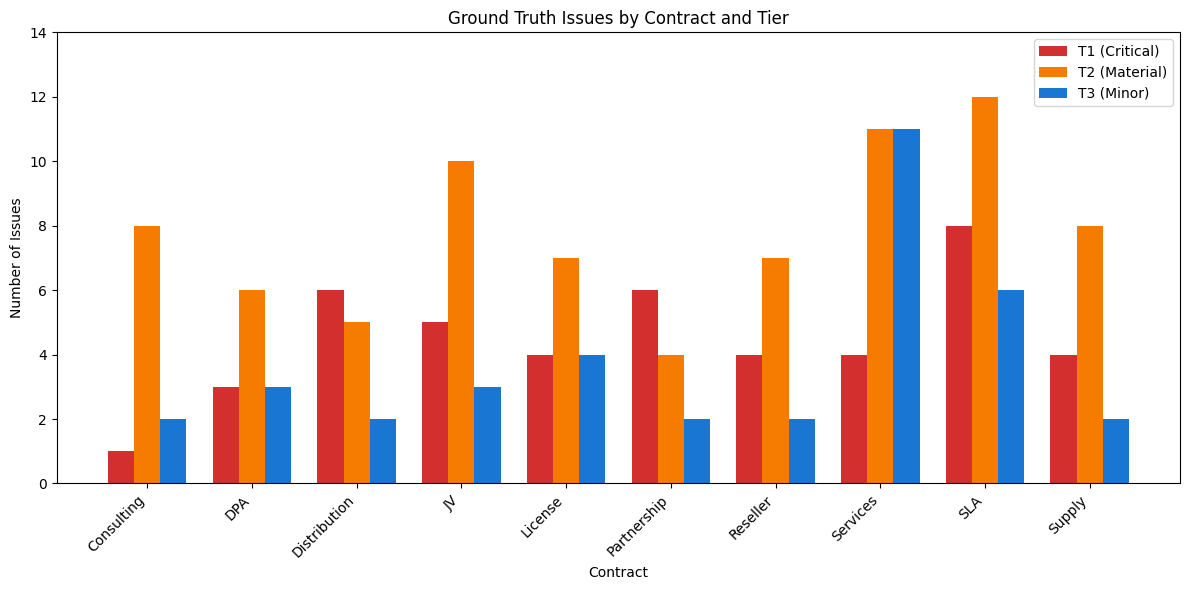

In [3]:
# Visualise: issues per contract by tier
fig, ax = plt.subplots(figsize=(12, 6))

x = np.arange(len(gt_df))
width = 0.25

bars_t1 = ax.bar(x - width, gt_df["T1"], width, label="T1 (Critical)", color="#d32f2f")
bars_t2 = ax.bar(x, gt_df["T2"], width, label="T2 (Material)", color="#f57c00")
bars_t3 = ax.bar(x + width, gt_df["T3"], width, label="T3 (Minor)", color="#1976d2")

ax.set_xlabel("Contract")
ax.set_ylabel("Number of Issues")
ax.set_title("Ground Truth Issues by Contract and Tier")
ax.set_xticks(x)
ax.set_xticklabels(gt_df["Contract"], rotation=45, ha="right")
ax.legend()
ax.set_ylim(0, max(gt_df[["T1", "T2", "T3"]].max()) + 2)

plt.tight_layout()
plt.show()

## Scoring System

Each ground truth issue is scored on two axes:

### Detection (did the model find the issue?)

| Value | Meaning | T1 Points | T2 Points | T3 Points |
|-------|---------|-----------|-----------|----------|
| **Y** | Fully detected and addressed | 8 | 5 | 1 |
| **P** | Partially detected | 4 | 2.5 | 0.5 |
| **N** | Missed (false negative) | 0 | 0 | 0 |
| **NMI** | Not mentioned anywhere | 0 | 0 | 0 |

### Quality (how good was the fix?)

Three dimensions, each scored 1-3 (only when detection = Y or P):

- **Amendment Quality**: Does the proposed fix address all key elements?
- **Rationale Quality**: Is the legal reasoning substantive and specific?
- **Redline Quality**: Is the proposed language precise and well-placed?

### Gates

- **T1 Gate**: ALL T1 issues must be detected (Y or P). Missing any T1 = automatic FAIL.
- **Total Score**: Detection points + quality points across all issues.

In [4]:
# Demo: scoring functions from the framework

examples = [
    ("Y", "T1", "Critical issue fully detected"),
    ("P", "T1", "Critical issue partially detected"),
    ("NMI", "T1", "Critical issue missed entirely"),
    ("Y", "T2", "Material issue fully detected"),
    ("P", "T2", "Material issue partially detected"),
    ("Y", "T3", "Minor issue fully detected"),
]

print("Detection Point Calculation Examples")
print("=" * 60)
for detection, tier, description in examples:
    points = calculate_detection_points(detection, tier, tier_config)
    print(f"  {description}")
    print(f"    Detection={detection}, Tier={tier} -> {points} points")
    print()

Detection Point Calculation Examples
  Critical issue fully detected
    Detection=Y, Tier=T1 -> 8 points

  Critical issue partially detected
    Detection=P, Tier=T1 -> 4 points

  Critical issue missed entirely
    Detection=NMI, Tier=T1 -> 0 points

  Material issue fully detected
    Detection=Y, Tier=T2 -> 5 points

  Material issue partially detected
    Detection=P, Tier=T2 -> 2.5 points

  Minor issue fully detected
    Detection=Y, Tier=T3 -> 1 points



In [5]:
# Load one evaluation result and walk through the evidence
sample_contract = "consulting"
sample_model = "sonnet45"

eval_path = RESULTS_DIR / sample_contract / f"{sample_model}.json"
with open(eval_path) as f:
    evaluation = json.load(f)

print(f"Evaluation: {sample_contract} / {sample_model}")
print(f"GT Version: {evaluation['meta']['gt_version']}")
print(f"Issues evaluated: {len(evaluation['gt_evaluations'])}")
print()

# Show first GT issue evaluation with evidence
gt_eval = evaluation["gt_evaluations"][0]
print(f"--- {gt_eval['gt_id']}: {gt_eval['issue']} ---")
print(f"Clause: {gt_eval['clause']}")
print(f"Tier: {gt_eval['tier']}")
print(f"Detection: {gt_eval['detection']}")
print(f"Detection Points: {gt_eval['detection_points']}")
print(f"Quality: amendment={gt_eval.get('amendment_score')}, "
      f"rationale={gt_eval.get('rationale_score')}, "
      f"redline={gt_eval.get('redline_quality_score')}")
print(f"Total Points: {gt_eval['total_points']}")

evidence = gt_eval.get("evidence", {})
excerpt = evidence.get("proposed_revision_excerpt", "(no excerpt)")
reasoning = evidence.get("judge_reasoning", "(no reasoning)")

print()
print("Evidence (proposed revision excerpt):")
print(f"  {excerpt[:200]}..." if len(str(excerpt)) > 200 else f"  {excerpt}")
print()
print("Judge reasoning:")
print(f"  {reasoning[:300]}..." if len(str(reasoning)) > 300 else f"  {reasoning}")

Evaluation: consulting / sonnet45
GT Version: 3.0_v4-enhanced_LOCKED
Issues evaluated: 11

--- GT-01: Work-for-hire designation likely ineffective - IP ownership at risk ---
Clause: 5.1
Tier: T1
Detection: Y
Detection Points: 8.0
Quality: amendment=3, rationale=3, redline=3
Total Points: 17.0

Evidence (proposed revision excerpt):
  All deliverables... shall be deemed 'work-for-hire under U.S. copyright law' and shall be owned exclusively by Client immediately upon creation. To the extent any deliverable does not qualify as work-...

Judge reasoning:
  Risk table flags ownership as Requires Clarification, noting work-for-hire with payment contingency creates ownership ambiguity. Proposed redline addresses work-for-hire limitations by providing immediate ownership upon creation and adding fallback assignment language for deliverables that don't qua...


In [6]:
# Calculate weighted recall for one model on one contract
scored_issues = [
    {"detection": e["detection"], "gt_tier": e["tier"]}
    for e in evaluation["gt_evaluations"]
]

actual, maximum, recall = calculate_weighted_recall(
    scored_issues, tier_config,
    detection_field="detection",
    tier_field="gt_tier",
)

print(f"Weighted Recall: {sample_contract} / {sample_model}")
print(f"  Actual detection points: {actual}")
print(f"  Maximum possible:        {maximum}")
print(f"  Weighted recall:         {recall:.1%}")
print()

# Per-tier breakdown
for tier in ["T1", "T2", "T3"]:
    tier_issues = [i for i in scored_issues if i["gt_tier"] == tier]
    if not tier_issues:
        continue
    detected = sum(1 for i in tier_issues if i["detection"] in ("Y", "P"))
    print(f"  {tier}: {detected}/{len(tier_issues)} detected")

Weighted Recall: consulting / sonnet45
  Actual detection points: 50.0
  Maximum possible:        50.0
  Weighted recall:         100.0%

  T1: 1/1 detected
  T2: 8/8 detected
  T3: 2/2 detected


In [7]:
# Load _summary.json and build full model comparison table
with open(RESULTS_DIR / "_summary.json") as f:
    summary = json.load(f)

total_issues = sum(tier_counts.values())
model_rows = []

for model_id, data in summary["by_model"].items():
    dc = data["detection_counts"]
    detected = dc["Y"] + dc["P"]
    detection_rate = detected / total_issues
    qt = data["quality_totals"]
    total_quality = qt["rationale"] + qt["amendment"] + qt["redline"]
    avg_quality = total_quality / (3 * detected) if detected > 0 else 0
    model_rows.append({
        "Model": model_id,
        "Total Points": data["total_points"],
        "Detection Rate": detection_rate,
        "Y": dc["Y"],
        "P": dc["P"],
        "N": dc["N"],
        "NMI": dc["NMI"],
        "T1 Pass": data["t1_pass"],
        "T1 Fail": data["t1_fail"],
        "Avg Quality": avg_quality,
    })

model_df = pd.DataFrame(model_rows).sort_values("Total Points", ascending=False)

# Display-formatted copy (keeps model_df numeric for later use)
display_df = model_df.copy()
display_df["Detection Rate"] = display_df["Detection Rate"].map("{:.1%}".format)
display_df["T1 Pass"] = display_df["T1 Pass"].astype(str) + "/10"
display_df["Avg Quality"] = display_df["Avg Quality"].map("{:.2f}".format)
display_df = display_df.drop(columns=["T1 Fail"])
display_df

,Model,Total Points,Detection Rate,Y,P,N,NMI,T1 Pass,Avg Quality
1,pioneer_deep,2049.5,95.0%,147,5,1,7,6/10,2.89
4,sonnet45,2048.0,94.4%,148,3,1,8,5/10,2.90
3,starliner,1736.5,87.5%,125,15,3,17,3/10,2.54
2,pathfinder,1691.0,84.4%,119,16,5,21,5/10,2.61
0,scale,1678.0,84.4%,114,21,2,23,7/10,2.56
5,velocity,1148.5,66.2%,74,32,0,54,2/10,2.17


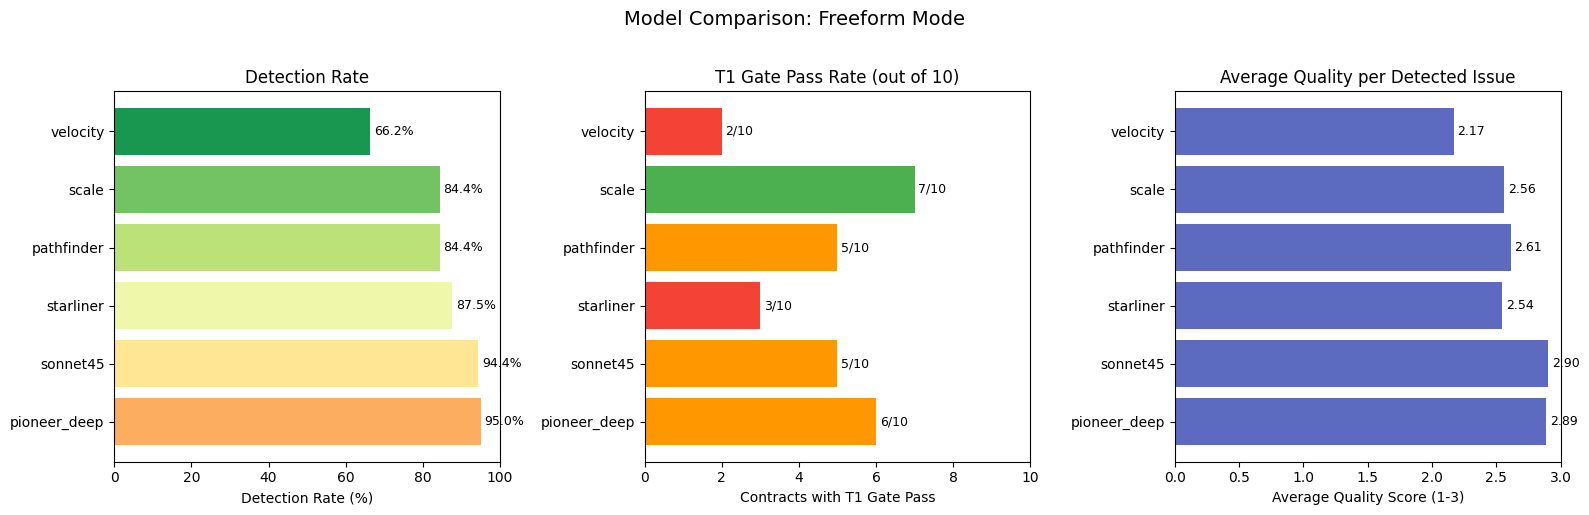

In [8]:
# Visualise: model comparison — detection rate, T1 pass rate, avg quality
fig, axes = plt.subplots(1, 3, figsize=(16, 5))

# Prepare data sorted by total points
sorted_models = model_df["Model"].tolist()
by_model = summary["by_model"]

# 1. Detection rate
det_rates = []
for m in sorted_models:
    dc = by_model[m]["detection_counts"]
    det_rates.append((dc["Y"] + dc["P"]) / total_issues * 100)

colors = plt.cm.RdYlGn(np.linspace(0.3, 0.9, len(sorted_models)))
axes[0].barh(sorted_models, det_rates, color=colors)
axes[0].set_xlabel("Detection Rate (%)")
axes[0].set_title("Detection Rate")
axes[0].set_xlim(0, 100)
for i, v in enumerate(det_rates):
    axes[0].text(v + 1, i, f"{v:.1f}%", va="center", fontsize=9)

# 2. T1 pass rate
t1_passes = [by_model[m]["t1_pass"] for m in sorted_models]
t1_colors = ["#4caf50" if p >= 7 else "#ff9800" if p >= 5 else "#f44336" for p in t1_passes]
axes[1].barh(sorted_models, t1_passes, color=t1_colors)
axes[1].set_xlabel("Contracts with T1 Gate Pass")
axes[1].set_title("T1 Gate Pass Rate (out of 10)")
axes[1].set_xlim(0, 10)
for i, v in enumerate(t1_passes):
    axes[1].text(v + 0.1, i, f"{v}/10", va="center", fontsize=9)

# 3. Avg quality score
avg_quals = []
for m in sorted_models:
    dc = by_model[m]["detection_counts"]
    detected = dc["Y"] + dc["P"]
    qt = by_model[m]["quality_totals"]
    total_q = qt["rationale"] + qt["amendment"] + qt["redline"]
    avg_quals.append(total_q / (3 * detected) if detected > 0 else 0)

axes[2].barh(sorted_models, avg_quals, color="#5c6bc0")
axes[2].set_xlabel("Average Quality Score (1-3)")
axes[2].set_title("Average Quality per Detected Issue")
axes[2].set_xlim(0, 3)
for i, v in enumerate(avg_quals):
    axes[2].text(v + 0.03, i, f"{v:.2f}", va="center", fontsize=9)

plt.suptitle("Model Comparison: Freeform Mode", fontsize=14, y=1.02)
plt.tight_layout()
plt.show()

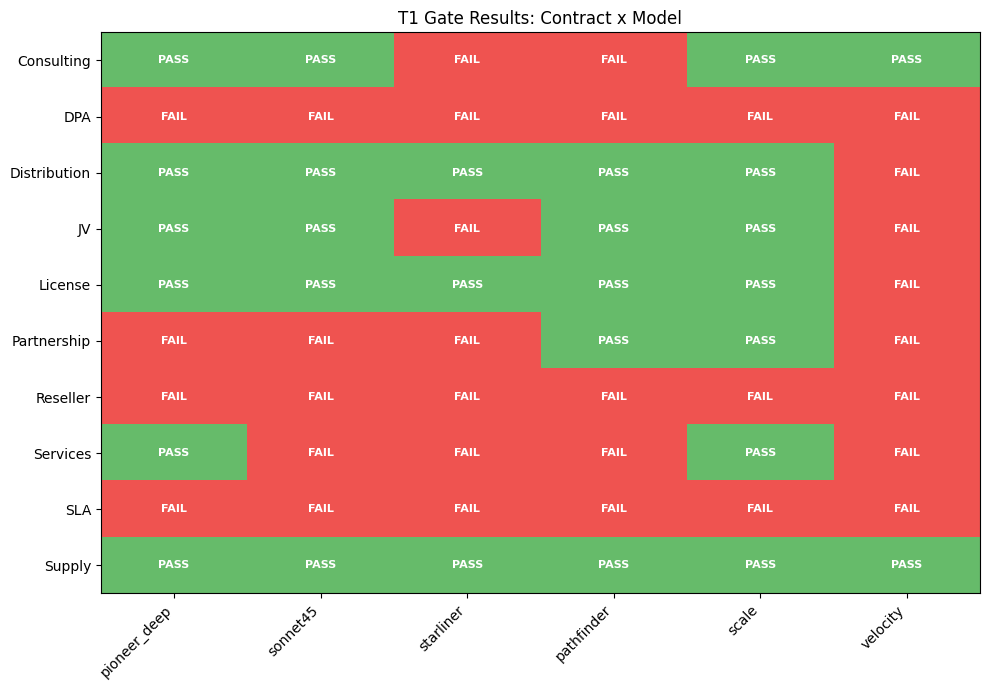

T1 Gate Pass Count by Model:
  pioneer_deep: 6/10
  sonnet45: 5/10
  starliner: 3/10
  pathfinder: 5/10
  scale: 7/10
  velocity: 2/10


In [9]:
# T1 Gate Heatmap: contracts x models
by_contract = summary["by_contract"]

heatmap_data = []
for contract in contracts:
    row = []
    for model in sorted_models:
        if contract in by_contract and model in by_contract[contract]:
            passed = by_contract[contract][model].get("t1_gate_pass", False)
            row.append(1 if passed else 0)
        else:
            row.append(-1)  # missing data
    heatmap_data.append(row)

heatmap_arr = np.array(heatmap_data)

fig, ax = plt.subplots(figsize=(10, 7))

# Three-colour map: red (FAIL=0), green (PASS=1), grey (missing=-1)
cmap = mcolors.ListedColormap(["#9e9e9e", "#ef5350", "#66bb6a"])
bounds = [-1.5, -0.5, 0.5, 1.5]
norm = mcolors.BoundaryNorm(bounds, cmap.N)

im = ax.imshow(heatmap_arr, cmap=cmap, norm=norm, aspect="auto")

ax.set_xticks(range(len(sorted_models)))
ax.set_xticklabels(sorted_models, rotation=45, ha="right")
ax.set_yticks(range(len(contracts)))
ax.set_yticklabels([CONTRACT_LABELS.get(c, c) for c in contracts])

# Annotations: PASS / FAIL / N/A
for i in range(len(contracts)):
    for j in range(len(sorted_models)):
        val = heatmap_arr[i, j]
        if val == -1:
            text, color = "N/A", "#424242"
        elif val == 1:
            text, color = "PASS", "white"
        else:
            text, color = "FAIL", "white"
        ax.text(j, i, text, ha="center", va="center", fontsize=8,
                color=color, fontweight="bold")

ax.set_title("T1 Gate Results: Contract x Model")
plt.tight_layout()
plt.show()

# Summary stats — count only actual passes, ignore missing
pass_counts = (heatmap_arr == 1).sum(axis=0)
print("T1 Gate Pass Count by Model:")
for m, p in zip(sorted_models, pass_counts):
    print(f"  {m}: {p}/10")

## Five Evaluation Modes

The framework supports five evaluation modes, each testing a different aspect of contract review capability:

| Mode | What It Tests | Contracts | Context | Status |
|------|---------------|-----------|---------|--------|
| **Freeform** | Risk identification with no guidance | 10 | None | Complete (results above) |
| **Freeform Stacking** | Response to counterparty redlines | 10 | Redlined contracts | Complete |
| **Rules** | Compliance with deterministic rules | 20 | Rule CSV | GT ready |
| **Rules Stacking** | Redline-specific rule application | 10 | Redlined + Rule CSV | GT ready |
| **Guidelines** | Playbook position guidance | 20 | Playbook (GS/FB1/FB2/RF) | GT ready |

Each mode has its own scoring configuration, ground truth structure, and gate criteria.
See the `docs/modes/` directory for detailed documentation on each mode.

In [10]:
# Load Rules and Guidelines GT to show different structures
rules_gt_path = PROJECT_ROOT / "rules" / "ground_truth" / "nda.json"
guidelines_gt_path = PROJECT_ROOT / "guidelines" / "ground_truth" / "nda.json"

print("=" * 60)
print("RULES MODE GT STRUCTURE")
print("=" * 60)
if rules_gt_path.exists():
    with open(rules_gt_path) as f:
        rules_gt = json.load(f)
    # Show metadata and first rule
    if "gt_metadata" in rules_gt:
        print(f"Contract type: {rules_gt['gt_metadata'].get('contract_type', 'N/A')}")
        print(f"Version: {rules_gt['gt_metadata'].get('gt_version', 'N/A')}")
    gt_key = "ground_truth" if "ground_truth" in rules_gt else "rule_evaluations"
    if gt_key in rules_gt:
        rules = rules_gt[gt_key]
        print(f"Total rules: {len(rules)}")
        if rules:
            print(f"\nFirst rule (sample):")
            print(json.dumps(rules[0], indent=2)[:500])
    else:
        print(f"Keys: {list(rules_gt.keys())}")
        # Try to find the rules array
        for key in rules_gt:
            if isinstance(rules_gt[key], list) and len(rules_gt[key]) > 0:
                print(f"\nFound array at '{key}' with {len(rules_gt[key])} items")
                print(json.dumps(rules_gt[key][0], indent=2)[:500])
                break
else:
    print("Rules GT not found")

print()
print("=" * 60)
print("GUIDELINES MODE GT STRUCTURE")
print("=" * 60)
if guidelines_gt_path.exists():
    with open(guidelines_gt_path) as f:
        guidelines_gt = json.load(f)
    if "gt_metadata" in guidelines_gt:
        print(f"Contract type: {guidelines_gt['gt_metadata'].get('contract_type', 'N/A')}")
        print(f"Version: {guidelines_gt['gt_metadata'].get('gt_version', 'N/A')}")
    gt_key = "ground_truth" if "ground_truth" in guidelines_gt else list(guidelines_gt.keys())[1]
    if gt_key in guidelines_gt and isinstance(guidelines_gt[gt_key], list):
        items = guidelines_gt[gt_key]
        print(f"Total items: {len(items)}")
        if items:
            print(f"\nFirst item (sample):")
            print(json.dumps(items[0], indent=2)[:500])
    else:
        print(f"Keys: {list(guidelines_gt.keys())}")
        for key in guidelines_gt:
            if isinstance(guidelines_gt[key], list) and len(guidelines_gt[key]) > 0:
                print(f"\nFound array at '{key}' with {len(guidelines_gt[key])} items")
                print(json.dumps(guidelines_gt[key][0], indent=2)[:500])
                break
else:
    print("Guidelines GT not found")

RULES MODE GT STRUCTURE
Contract type: NDA
Version: 1.0_LOCKED
Total rules: 38

First rule (sample):
{
  "test_id": "TechPartners_Bi_01",
  "contract": "NDA_TechPartners_Bilateral",
  "clause_ref": "1.1",
  "rule_name": "CI Definition - Unmarked Information Deletion",
  "expected_action": "DELETE",
  "trigger_quote": "whether or not expressly designated or labeled as confidential",
  "key_elements": [
    "Delete unmarked/undesignated language",
    "Preserve remainder of CI definition"
  ],
  "rationale_must_include": [
    "Unmarked info creates overbroad scope",
    "Receiving Party cannot i

GUIDELINES MODE GT STRUCTURE
Contract type: NDA
Version: 1.0_LOCKED
Total items: 45

First item (sample):
{
  "test_id": "TechPartnersBilateral_01",
  "contract": "NDA_TechPartners_Bilateral",
  "clause_ref": "Section 1.1",
  "clause_name": "CI Definition",
  "playbook_ref": 1,
  "playbook_standard": "Red Flag",
  "tier": 1,
  "trigger_phrase": "whether or not marked as confidential",
  "expect

## Summary

This notebook demonstrated the core evaluation pipeline:

1. **Ground truth** defines what a competent lawyer should identify, with 160+ issues tiered by materiality
2. **Scoring** combines detection (did the model find it?) with quality (how good was the fix?)
3. **Gates** enforce minimum standards — missing any T1 (critical) issue is an automatic failure
4. **Semantic matching** evaluates risk identification, not clause number matching

### Further Reading

- [Scoring Methodology](../docs/scoring_methodology.md) — Complete tier system, quality rubrics, and formulae
- [Ground Truth Principles](../docs/ground_truth_principles.md) — How GT issues are authored and tiered
- [Evaluation Integrity](../docs/evaluation_integrity.md) — Data governance and versioning
- [Mode Documentation](../docs/modes/) — Detailed docs for each evaluation mode
- [Evaluation Prompts](../prompts/) — Agent specifications used to execute evaluations